In [42]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit import Aer
from qiskit.opflow import X, Z, I, MatrixEvolution
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit import Parameter
from qiskit import transpile
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
from qutip import *
import itertools as it
import copy
import stomp_functions as stf
from qiskit.quantum_info import random_clifford
import time
from qiskit.providers.fake_provider import FakeAthens, FakeBelem

In [43]:
def integrate_setup(N, g, J):
    # Create pauli matrices
    si = qeye(2)
    sz = sigmaz()
    sx = sigmax()
    sm = sigmam()

    # Create lists for the operators and wf
    op_list = []
    wf_list = []
    
    # Define basis for wf
    wf = basis(2, 1)
    
    # Fill lists so that we can create the full tensor
    for m in range(N):
        wf_list.append(wf)
    
    # Create full tensor
    wf_tensor = tensor(wf_list)
    
    # Construct lists for the x and z Paulis
    sx_list = []
    sz_list = []

    # Normalize wf tensor
    init = wf_tensor.unit()
    
    # Construct different combinations of Paulis for the Hamiltonian
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N-1):
        H += -J * sz_list[n] * sz_list[n+1]
        for m in range(N):
            H += -J * g * sx_list[n]

    #E_0 = H.eigenenergies(eigvals=1)[0]
    E, V = linalg.eigh(H.data.toarray())
    print(E[0])

    if E[0] < 0:
        H -= 1.5 * E[0]
        # H=(2**N)*H/H.tr()
    print(J, g)

    print("Hamiltonian and dissipators constructed.")
    print("Shape of H is {}, and Hermitian check returned {}".format(H.shape,H.isherm))
    
    return H, sz_list, sx_list, init

In [44]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [45]:
backend = Aer.get_backend('aer_simulator')
num_shots = 1*8192

## Basic N=1 example for Hadamard Estimation

In [46]:
N = 1
g = 2
j = 1

In [47]:
# Set up parameters for unitary
beta = 0.2
num_steps = 500
betas, dt = np.linspace(0, beta, num_steps, retstep=True)

In [48]:
z_list, x_list = stf.construct_op_lists(N)

In [49]:
# Construct the Hamiltonian
# Loop over sites to construct parts of H
H_qis = -j * Z - j * g * X

# Get eigenenergies from H
E_qis, V_qis = linalg.eigh(H_qis.to_matrix())

In [50]:
# Define initial wavefunction
init_wf = np.array([1, 0])

# Create circuit registers
qr = QuantumRegister(1)
qar = AncillaRegister(1)
cr = ClassicalRegister(1)
cliff = random_clifford(N, seed=5)
init_wf = cliff.to_matrix() @ init_wf

In [52]:
# Get circuits for real and imaginary Hadamard estimation with no observable
#he_circs_re = stf.hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, 
#                                      dt, cliff)
#he_circs_im = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, 
#                                           dt, cliff)

he_circs_re = stf.hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, 
                                      dt, cliff)
he_circs_im = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, 
                                      dt, cliff)

In [53]:
# Get the overlap lists for the circuits with no observables
ovlps_r = stf.get_ovlps(he_circs_re, backend, num_shots)
ovlps_i = stf.get_ovlps(he_circs_im, backend, num_shots)
ovlps = ovlps_r + 1j * ovlps_i

In [54]:
# Now that we have the overlaps, we want to calculate the expectation value of H at each step
pauli_H = stf.pauli_string_decomp(H_qis)

In [63]:
# Now perform hadmard estimation on each string
H_circs_r = {}
H_circs_i = {}
for key in pauli_H:
    if abs(pauli_H[key]) != 0:
        H_circs_r[key] = stf.hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps, dt,
                                                 cliff)
        
        H_circs_i[key] = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps,
                                                                   dt, cliff)

In [64]:
# Get real part of H expectations
H_ovlps_re = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re += pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [65]:
# Get imag part of H expectations
H_ovlps_im = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im += 1j * pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [66]:
# Get total H expectation
total_H_ovlp = H_ovlps_re + H_ovlps_im

In [67]:
# Classical calculation
class_ovlp, class_E_ovlp = stf.classical_calc(np.array(init_wf), H_qis.to_matrix(),
                                              H_qis.to_matrix(), num_steps, dt)

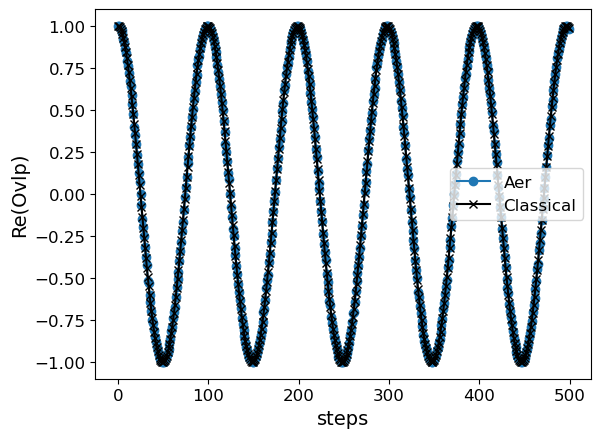

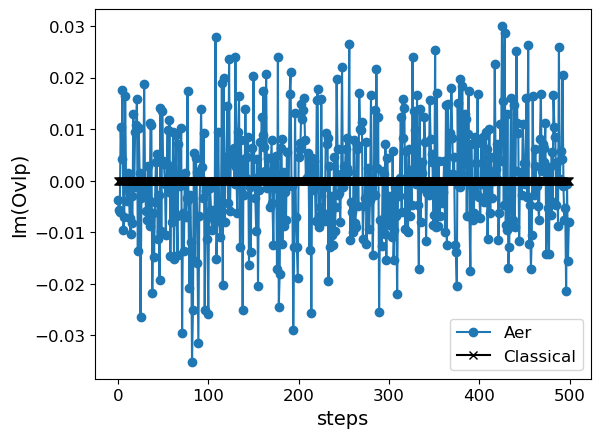

In [68]:
plt.figure(1)
plt.plot(ovlps.real, 'o-', label='Aer')
plt.plot(class_ovlp.real, 'kx-', label='Classical')
plt.ylabel("Re(Ovlp)")
plt.xlabel("steps")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(ovlps.imag, 'o-', label='Aer')
plt.plot(class_ovlp.imag, 'kx-', label='Classical')
plt.ylabel("Im(Ovlp)")
plt.xlabel("steps")
plt.legend(numpoints=1)

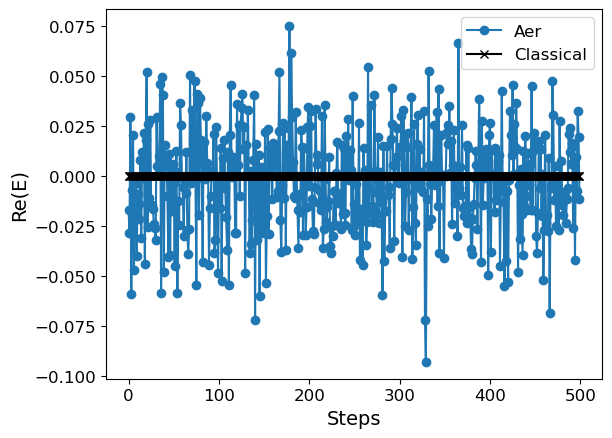

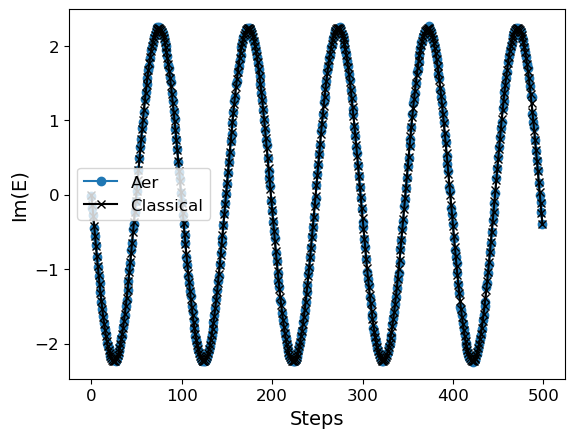

In [69]:
plt.figure(1)
plt.plot(total_H_ovlp.real, 'o-', label='Aer')
plt.plot(class_E_ovlp.real, 'kx-', label='Classical')
plt.xlabel("Steps")
plt.ylabel("Re(E)")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(total_H_ovlp.imag, 'o-', label='Aer')
plt.plot(class_E_ovlp.imag, 'kx-', label='Classical')
plt.xlabel("Steps")
plt.ylabel("Im(E)")
plt.legend(numpoints=1)

/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Classical - N=1')

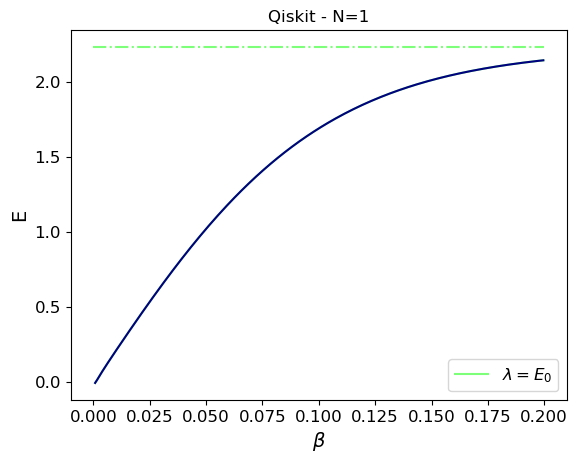

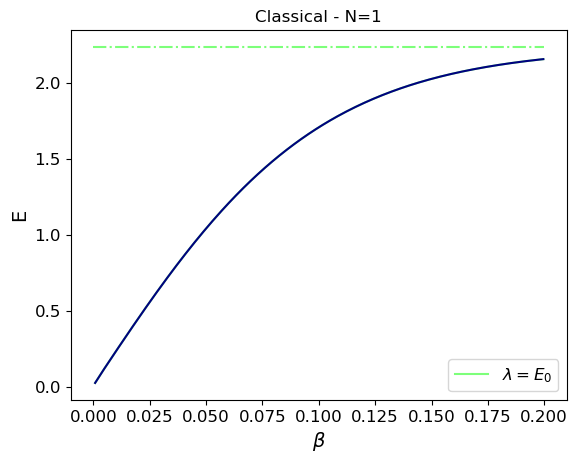

In [70]:
# Create colormap
colors = plt.cm.jet(np.linspace(0, 1, len(E_qis[::2])+2))
plt.figure(1)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()
plt.title("Qiskit - N="+str(N))

plt.figure(2)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.alt_partition_calc(class_ovlp, class_E_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.alt_partition_calc(class_ovlp, class_E_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()
plt.title("Classical - N="+str(N))

In [21]:
depths = [_.depth() for _ in he_circs_re]

In [22]:
depths[0], depths[1], depths[2]

(4, 6, 8)

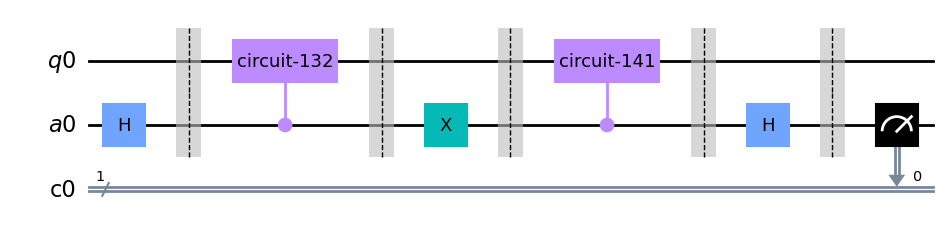

In [23]:
he_circs_re[1].draw('mpl')

Text(0, 0.5, 'Circuit Depth')

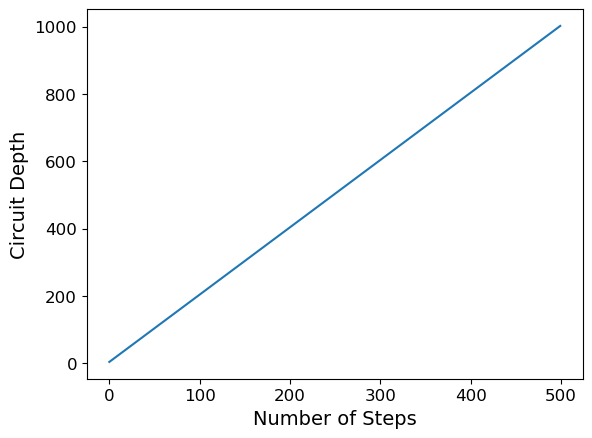

In [24]:
plt.plot(depths)
plt.xlabel("Number of Steps")
plt.ylabel("Circuit Depth")

## N=2 test

In [71]:
# Define system parameters
N = 2
g = 2
j = 1

In [72]:
# Set up parameters for unitary
beta = 0.2
num_steps = 200
backend = Aer.get_backend("aer_simulator")
betas, dt = np.linspace(0, beta, num_steps, retstep=True)

In [73]:
z_ops, x_ops = stf.construct_op_lists(N)

In [74]:
# Construct the Hamiltonian
# Loop over sites to construct parts of H
H_qis = 0
for n in range(N-1):
    H_qis += -j * z_ops[n] @ z_ops[n+1]
    for m in range(N):
        H_qis += -j * g * x_ops[n]

# Get eigenenergies from H
E_qis, V_qis = linalg.eigh(H_qis.to_matrix())

In [75]:
qr = QuantumRegister(N)
qar = AncillaRegister(1)
cr = ClassicalRegister(1)
init_wf = np.array([1, 0, 0, 0])
cliff = random_clifford(N, seed=5)
init_wf = cliff.to_matrix() @ init_wf

In [76]:
# Get circuits for real and imaginary Hadamard estimation with no observable
he_circs_re = stf.hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, 
                                      dt, cliff)
he_circs_im = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, 
                                           dt, cliff)

In [77]:
# Get the overlap lists for the circuits with no observables
ovlps_r = stf.get_ovlps(he_circs_re, backend, num_shots)
ovlps_i = stf.get_ovlps(he_circs_im, backend, num_shots)
ovlps = ovlps_r + 1j * ovlps_i

In [78]:
# Now that we have the overlaps, we want to calculate the expectation value of H at each step
pauli_H = stf.pauli_string_decomp(H_qis, N)

In [79]:
# Now perform hadmard estimation on each string
H_circs_r = {}
H_circs_i = {}
for key in pauli_H:
    if abs(pauli_H[key]) != 0:
        H_circs_r[key] = stf.hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps, dt,
                                                 cliff)
        
        H_circs_i[key] = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps,
                                                                   dt, cliff)

In [80]:
# Get real part of H expectations
H_ovlps_re = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re += pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [81]:
# Get imag part of H expectations
H_ovlps_im = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im += 1j * pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [82]:
# Get total H expectation
total_H_ovlp = H_ovlps_re + H_ovlps_im

In [83]:
# Classical calculation
class_ovlp, class_E_ovlp = stf.classical_calc(np.array(init_wf), H_qis.to_matrix(),
                                              H_qis.to_matrix(), num_steps, dt)

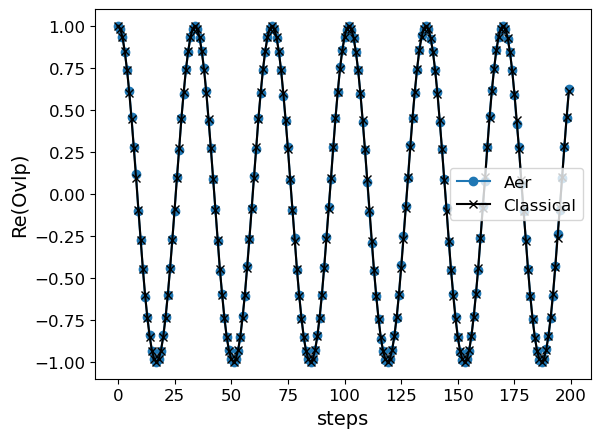

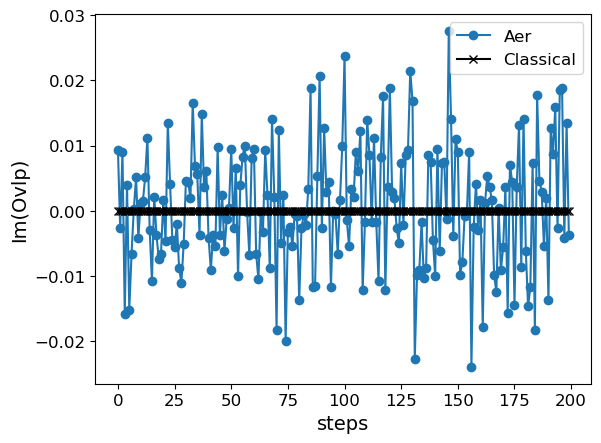

In [84]:
plt.figure(1)
plt.plot(ovlps.real, 'o-', label='Aer')
plt.plot(class_ovlp.real, 'kx-', label='Classical')
plt.ylabel("Re(Ovlp)")
plt.xlabel("steps")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(ovlps.imag, 'o-', label='Aer')
plt.plot(class_ovlp.imag, 'kx-', label='Classical')
plt.ylabel("Im(Ovlp)")
plt.xlabel("steps")
plt.legend(numpoints=1)

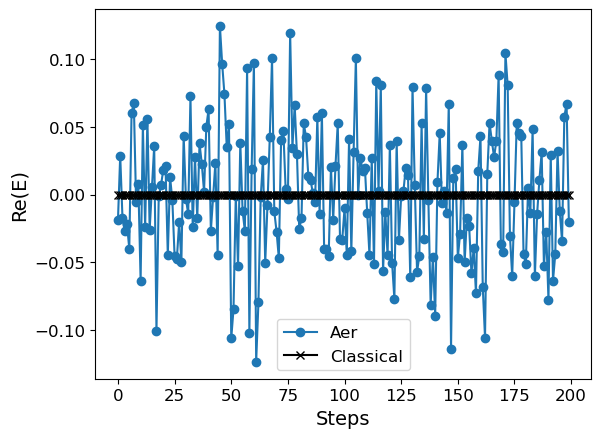

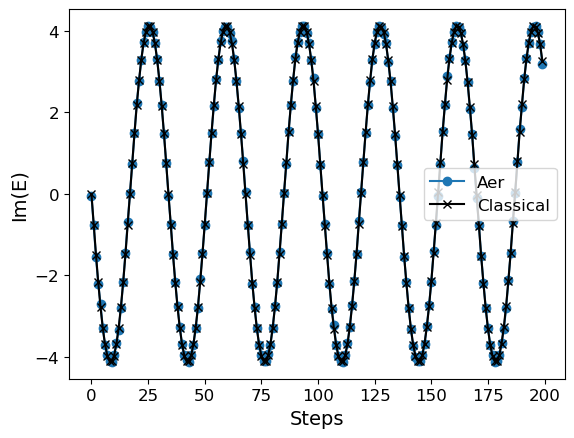

In [85]:
plt.figure(1)
plt.plot(total_H_ovlp.real, 'o-', label='Aer')
plt.plot(class_E_ovlp.real, 'kx-', label='Classical')
plt.xlabel("Steps")
plt.ylabel("Re(E)")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(total_H_ovlp.imag, 'o-', label='Aer')
plt.plot(class_E_ovlp.imag, 'kx-', label='Classical')
plt.xlabel("Steps")
plt.ylabel("Im(E)")
plt.legend(numpoints=1)

/home/jacob/anaconda3/envs/EnergyGaps/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Classical - N=2')

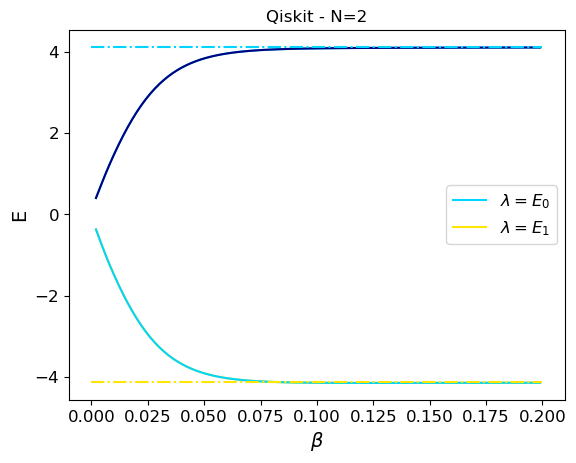

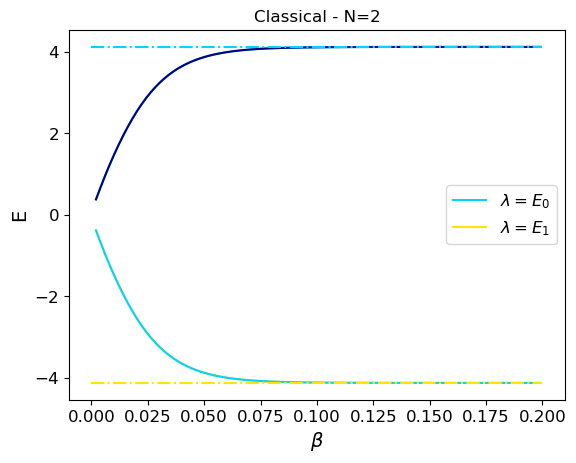

In [86]:
# Create colormap
colors = plt.cm.jet(np.linspace(0, 1, len(E_qis[::2])+2))
plt.figure(1)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()
plt.title("Qiskit - N="+str(N))

plt.figure(2)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.alt_partition_calc(class_ovlp, class_E_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.alt_partition_calc(class_ovlp, class_E_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()
plt.title("Classical - N="+str(N))

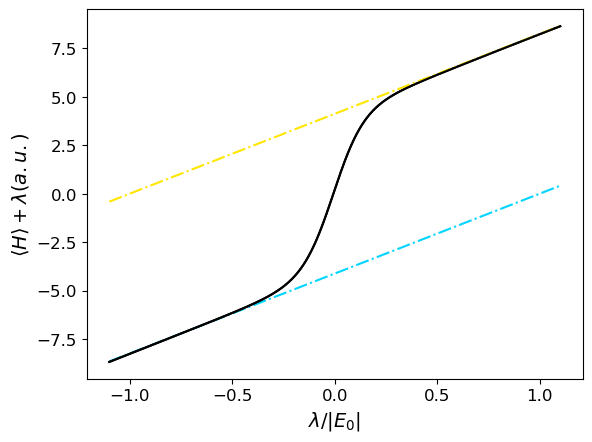

In [87]:
stf.plot_lambda_sweep(ovlps, total_H_ovlp, num_steps, dt, E_qis)

In [61]:
trans_re = transpile(he_circs_re, backend)
trans_im = transpile(he_circs_im, backend)
re_depths = [_.depth() for _ in trans_re]
im_depths = [_.depth() for _ in trans_re]

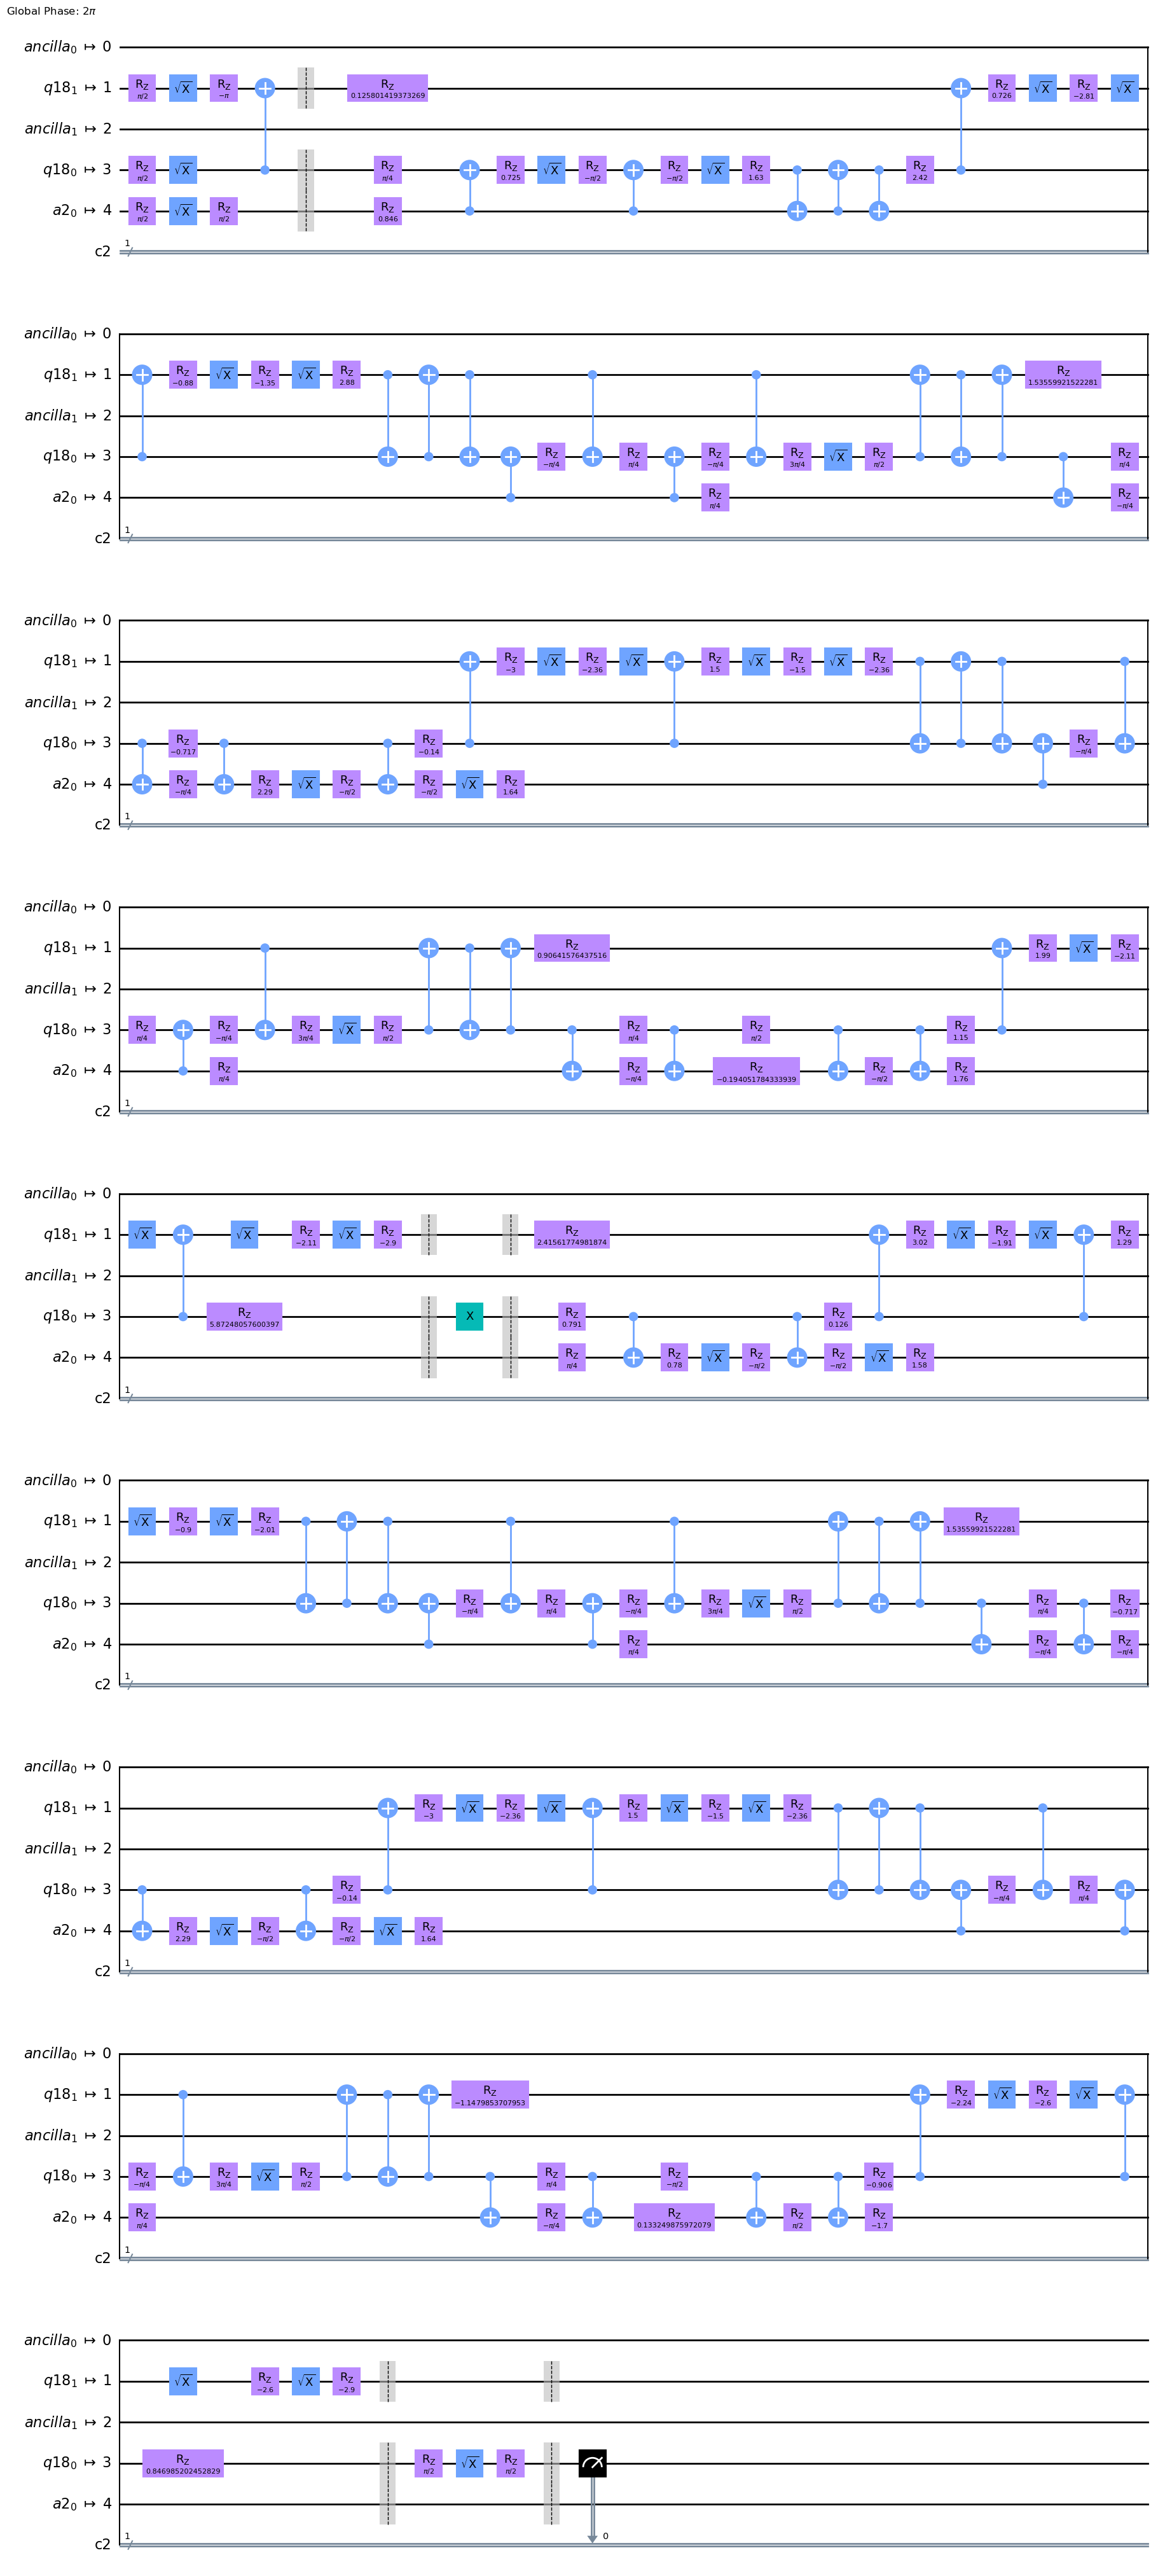

In [63]:
trans_re[1].draw('mpl')

Text(0, 0.5, 'Circuit Depth')

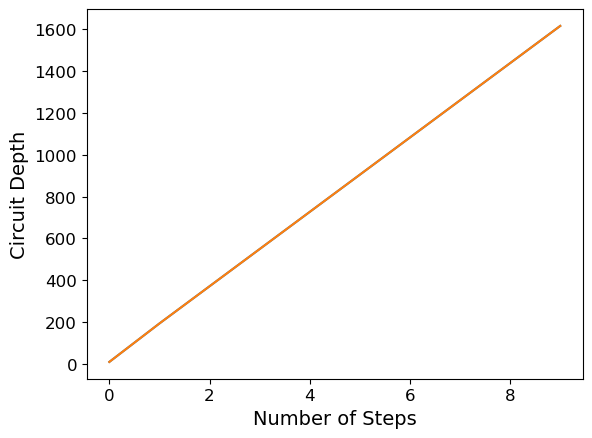

In [62]:
plt.plot(re_depths, label='Real')
plt.plot(im_depths, label='Imag')
plt.xlabel("Number of Steps")
plt.ylabel("Circuit Depth")

## N=3

In [38]:
# Define system parameters
N = 3
g = 2
j = 1

In [39]:
# Set up parameters for unitary
beta = 0.2
numsteps = 500
betas, dt = np.linspace(0, beta, numsteps, retstep=True)

In [40]:
z_ops, x_ops = stf.construct_op_lists(N)

In [41]:
# Construct the Hamiltonian
# Loop over sites to construct parts of H
H_qis = 0
for n in range(N-1):
    H_qis += -j * z_ops[n] @ z_ops[n+1]
    for m in range(N):
        H_qis += -j * g * x_ops[n]

# Get eigenenergies from H
E_qis, V_qis = linalg.eigh(H_qis.to_matrix())

In [42]:
qr = QuantumRegister(N)
qar = AncillaRegister(1)
cr = ClassicalRegister(1)
init_wf = [0 for i in range(2 ** N)]
init_wf[0] = 1
cliff = random_clifford(N, seed=5)
init_wf = cliff.to_matrix() @ init_wf

In [43]:
# Get circuits for real and imaginary Hadamard estimation with no observable
he_circs_re = stf.hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, 
                                      dt, cliff)
he_circs_im = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, 
                                           dt, cliff)

In [44]:
# Get the overlap lists for the circuits with no observables
ovlps_r = stf.get_ovlps(he_circs_re, backend, num_shots)
ovlps_i = stf.get_ovlps(he_circs_im, backend, num_shots)
ovlps = ovlps_r + 1j * ovlps_i

In [45]:
# Now that we have the overlaps, we want to calculate the expectation value of H at each step
pauli_H = stf.pauli_string_decomp(H_qis, N)

In [46]:
# Now perform hadmard estimation on each string
H_circs_r = {}
H_circs_i = {}
for key in pauli_H:
    if abs(pauli_H[key]) != 0:
        H_circs_r[key] = stf.hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps, dt,
                                                 cliff)
        
        H_circs_i[key] = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps,
                                                                   dt, cliff)

In [47]:
# Get real part of H expectations
H_ovlps_re = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re += pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [48]:
# Get imag part of H expectations
H_ovlps_im = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im += 1j * pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [49]:
# Get total H expectation
total_H_ovlp = H_ovlps_re + H_ovlps_im

In [50]:
# Classical calculation
class_ovlp, class_E_ovlp = stf.classical_calc(np.array(init_wf), H_qis.to_matrix(),
                                              H_qis.to_matrix(), num_steps, dt)

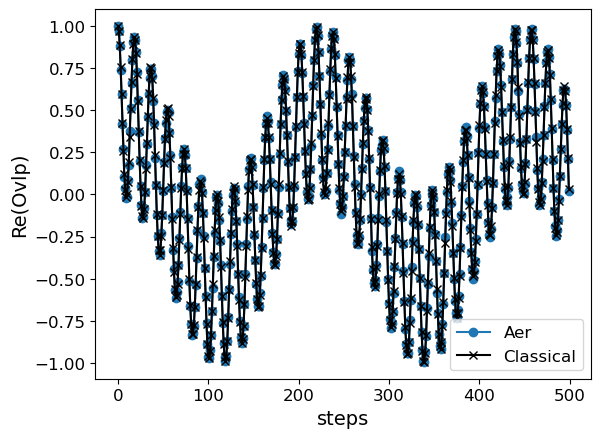

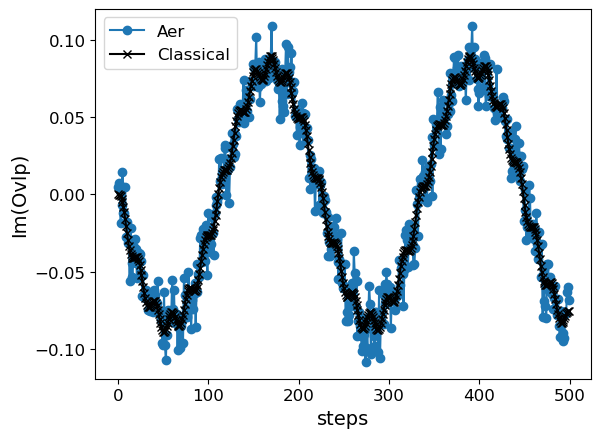

In [51]:
plt.figure(1)
plt.plot(ovlps.real, 'o-', label='Aer')
plt.plot(class_ovlp.real, 'kx-', label='Classical')
plt.ylabel("Re(Ovlp)")
plt.xlabel("steps")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(ovlps.imag, 'o-', label='Aer')
plt.plot(class_ovlp.imag, 'kx-', label='Classical')
plt.ylabel("Im(Ovlp)")
plt.xlabel("steps")
plt.legend(numpoints=1)

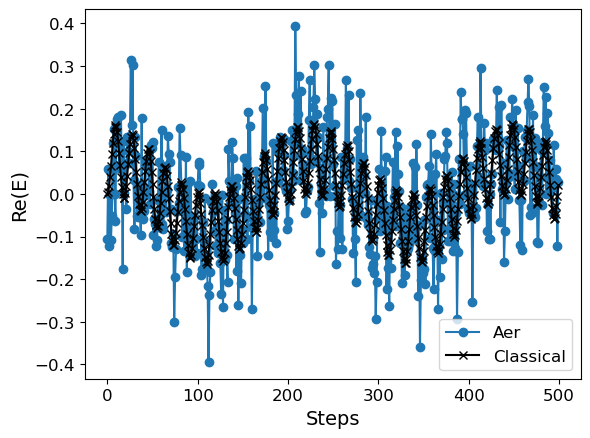

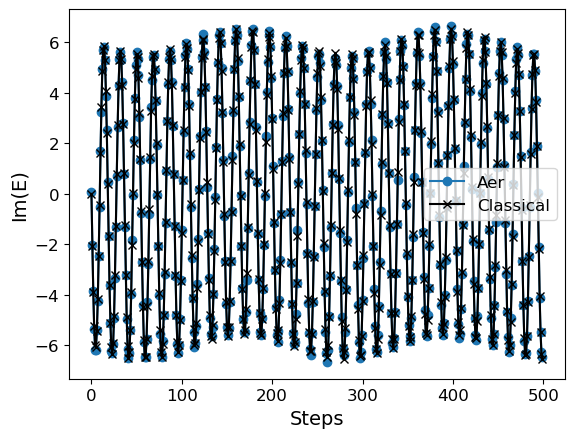

In [52]:
plt.figure(1)
plt.plot(total_H_ovlp.real, 'o-', label='Aer')
plt.plot(class_E_ovlp.real, 'kx-', label='Classical')
plt.xlabel("Steps")
plt.ylabel("Re(E)")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(total_H_ovlp.imag, 'o-', label='Aer')
plt.plot(class_E_ovlp.imag, 'kx-', label='Classical')
plt.xlabel("Steps")
plt.ylabel("Im(E)")
plt.legend(numpoints=1)

Text(0.5, 1.0, 'Classical - N=4')

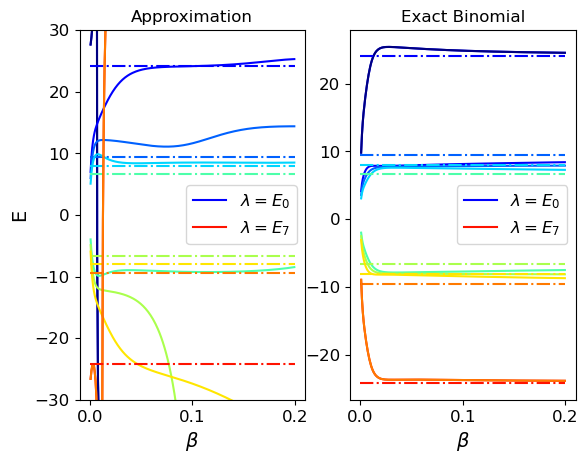

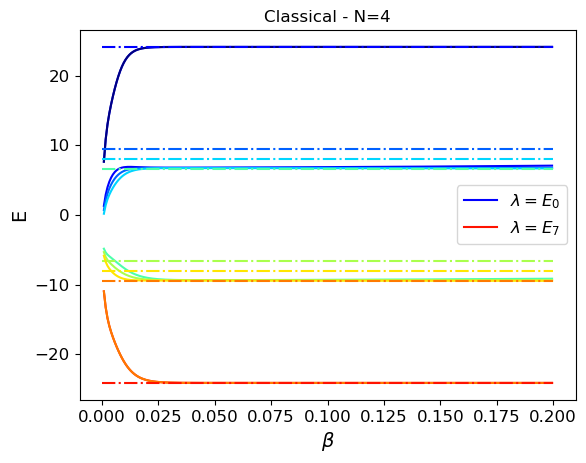

In [78]:
# Create colormap
colors = plt.cm.jet(np.linspace(0, 1, len(E_qis[::2])+2))
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1, 2, 1)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        ax1.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    ax1.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    ax1.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
ax1.set_xlabel("$\\beta$")
ax1.set_ylim([-30, 30])
ax1.set_ylabel("E")
ax1.legend()
ax1.set_title("Approximation")
#plt.savefig("aersim_N=4_approx.png", format='png', dpi=300)

colors = plt.cm.jet(np.linspace(0, 1, len(E_qis[::2])+2))
ax2 = fig1.add_subplot(1, 2, 2)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        ax2.plot(betas[2::2], stf.partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    ax2.plot(betas[2::2], stf.partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    ax2.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
ax2.set_xlabel("$\\beta$")
#.ylabel("E")
ax2.legend()
ax2.set_title("Exact Binomial")
plt.savefig("approx_vs_exact.png", format='png', dpi=300)


plt.figure(2)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.partition_calc(class_ovlp, class_E_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.partition_calc(class_ovlp, class_E_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()
plt.title("Classical - N="+str(N))

## N = 4

In [54]:
# Define system parameters
N = 4
g = 2
j = 1

In [55]:
# Set up parameters for unitary
beta = 0.2
numsteps = 500
betas, dt = np.linspace(0, beta, numsteps, retstep=True)

In [56]:
z_ops, x_ops = stf.construct_op_lists(N)

In [57]:
# Construct the Hamiltonian
# Loop over sites to construct parts of H
H_qis = 0
for n in range(N-1):
    H_qis += -j * z_ops[n] @ z_ops[n+1]
    for m in range(N):
        H_qis += -j * g * x_ops[n]

# Get eigenenergies from H
E_qis, V_qis = linalg.eigh(H_qis.to_matrix())

In [58]:
qr = QuantumRegister(N)
qar = AncillaRegister(1)
cr = ClassicalRegister(1)
init_wf = [0 for i in range(2 ** N)]
init_wf[0] = 1
cliff = random_clifford(N, seed=5)

In [59]:
# Get circuits for real and imaginary Hadamard estimation with no observable
he_circs_re = stf.hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, 
                                      dt, cliff)
he_circs_im = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, None, num_steps, 
                                           dt, cliff)

In [60]:
# Get the overlap lists for the circuits with no observables
ovlps_r = stf.get_ovlps(he_circs_re, backend, num_shots)
ovlps_i = stf.get_ovlps(he_circs_im, backend, num_shots)
ovlps = ovlps_r + 1j * ovlps_i

In [61]:
# Now that we have the overlaps, we want to calculate the expectation value of H at each step
pauli_H = stf.pauli_string_decomp(H_qis, N)

In [62]:
# Now perform hadmard estimation on each string
H_circs_r = {}
H_circs_i = {}
for key in pauli_H:
    if abs(pauli_H[key]) != 0:
        H_circs_r[key] = stf.hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps, dt,
                                                 cliff)
        
        H_circs_i[key] = stf.imag_hadamard_estimation(qr, qar, cr, H_qis, Pauli(key), num_steps,
                                                                   dt, cliff)

In [63]:
# Get real part of H expectations
H_ovlps_re = 0
for key in H_circs_r:
    temp = stf.get_ovlps(H_circs_r[key], backend, num_shots)
    H_ovlps_re += pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [64]:
# Get imag part of H expectations
H_ovlps_im = 0
for key in H_circs_i:
    temp = stf.get_ovlps(H_circs_i[key], backend, num_shots)
    H_ovlps_im += 1j * pauli_H[key] * temp / np.sqrt(2 ** (2*N))

In [65]:
# Get total H expectation
total_H_ovlp = H_ovlps_re + H_ovlps_im

In [66]:
# Classical calculation
class_ovlp, class_E_ovlp = stf.classical_calc(np.array(init_wf), H_qis.to_matrix(),
                                              H_qis.to_matrix(), num_steps, dt)

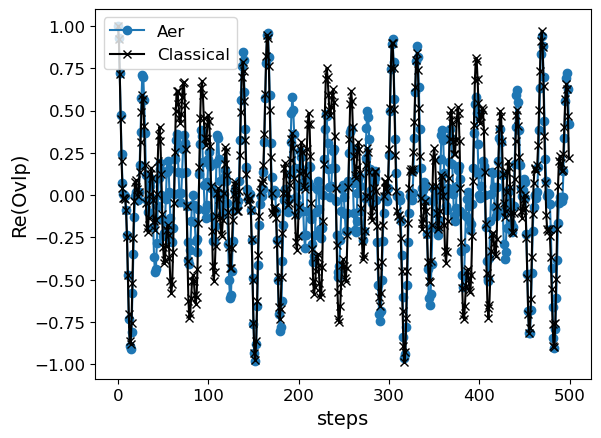

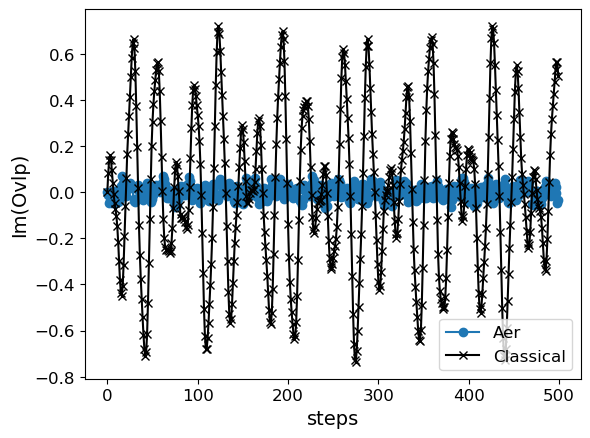

In [67]:
plt.figure(1)
plt.plot(ovlps.real, 'o-', label='Aer')
plt.plot(class_ovlp.real, 'kx-', label='Classical')
plt.ylabel("Re(Ovlp)")
plt.xlabel("steps")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(ovlps.imag, 'o-', label='Aer')
plt.plot(class_ovlp.imag, 'kx-', label='Classical')
plt.ylabel("Im(Ovlp)")
plt.xlabel("steps")
plt.legend(numpoints=1)

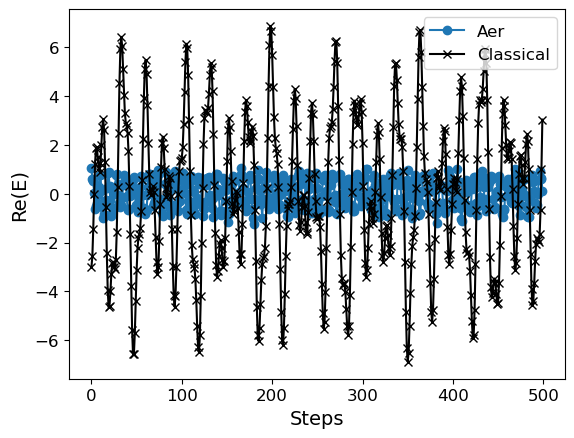

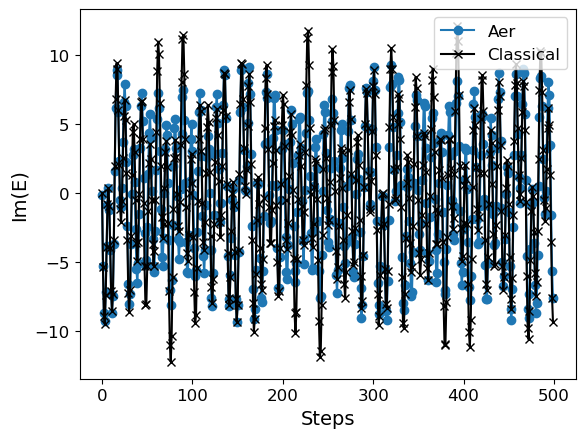

In [68]:
plt.figure(1)
plt.plot(total_H_ovlp.real, 'o-', label='Aer')
plt.plot(class_E_ovlp.real, 'kx-', label='Classical')
plt.xlabel("Steps")
plt.ylabel("Re(E)")
plt.legend(numpoints=1)

plt.figure(2)
plt.plot(total_H_ovlp.imag, 'o-', label='Aer')
plt.plot(class_E_ovlp.imag, 'kx-', label='Classical')
plt.xlabel("Steps")
plt.ylabel("Im(E)")
plt.legend(numpoints=1)

Text(0.5, 1.0, 'Classical - N=4')

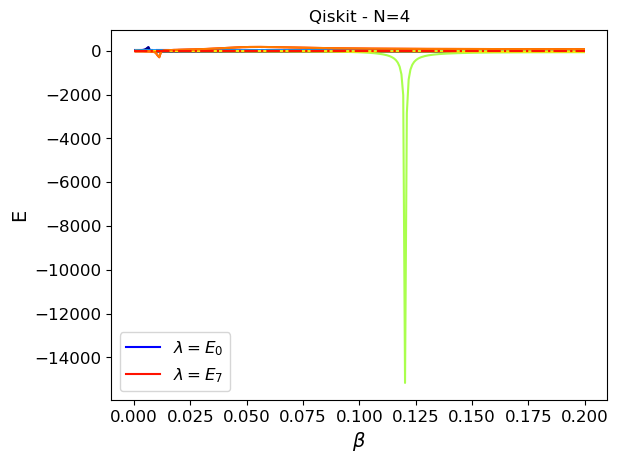

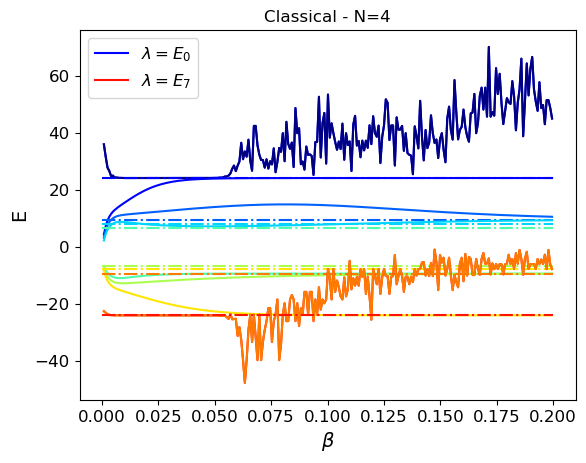

In [69]:
# Create colormap
colors = plt.cm.jet(np.linspace(0, 1, len(E_qis[::2])+2))
plt.figure(1)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, total_H_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()
plt.title("Qiskit - N="+str(N))

plt.figure(2)
l = 0
for e in E_qis[::2]:
    e = -e
    if l == 0 or l == len(E_qis[::2]) - 1:
        plt.plot(betas[2::2], stf.alt_partition_calc(class_ovlp, class_E_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l + 1],
                label='$\\lambda = E_' + str(l) + '$')
    plt.plot(betas[2::2], stf.alt_partition_calc(class_ovlp, class_E_ovlp, num_steps,
                                             e, dt)[1][1:]-e, color=colors[l])
    
    plt.plot(betas, e*np.ones(len(betas)), '-.', color=colors[l+1])
    l += 1
plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()
plt.title("Classical - N="+str(N))